Cargamos las librerías, el conjunto de datos y algunas variables que emplearemos durante el proceso:

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib inline

df = pickle.load(open('./processed_data/houses_cleaned.p',"rb"))

# Definimos las opciones de visualizacion
pd.set_option('display.max_columns', 500)

b = '\033[94m'  # para texto azul
n = '\033[0m'   # para texto normal

# Omitimos los warnings
warnings.filterwarnings('ignore')

# Selección de datos que se van a estudiar

En esta fase realizaremos un análisis exploratorio de los datos, con el claro objetivo de adquirir comprensión y conocimiento acerca de ellos. Ello por sí solo constituye ya un ejercicio interesante, ya que puede relevar relaciones o patrones que pueden sernos útiles a la hora de entender cómo varían ciertas propiedades de las viviendas en función de otras.

No obstante, esta fase se plantea también como una fase intermedia para el modelado que veremos más adelante, en el cual implementaremos un modelo de regresión con el que trataremos de **predecir el precio de las viviendas** a partir de algunas características. Es por ello que, en esta fase, trataremos sobretodo de entender qué relación juegan las distintas características para con el precio, a fin de poder escoger luego la mejor combinación de variables a la hora de implementar el modelo.

Pero, antes de proceder con el análisis exploratorio de los datos, realizaremos una preselección de variables en la cual descartaremos aquellas que no emplearemos.

In [2]:
df = df.drop(columns=['house_id','ad_description'])

Además, dividiremos el conjunto de datos en viviendas tipo piso y viviendas tipo casa/chalet, lo cual nos ayudará en nuestra fase exploratoria:

In [3]:
houses = df.house_type.isin(['Casa o chalet', 'Casa rural', 'Chalet adosado', 'Finca rústica', 'Otros'])   
flats = df.house_type.isin(['Piso', 'Dúplex', 'Ático', 'Estudio'])

# Creación de funciones para visualizaciones

En esta fase de exploración de datos necesitaremos generar múltiples y variadas visualizaciones, ya sean para describir distribuciones, así como para reflejar distintas relaciones entre variables. Para ello, la mejor opción es generar gráficos *ad-hoc* que reflejen nuestros datos de la forma más clara posible. No obstante, generar gráficos personalizados requiere muchas líneas de código, y puede acarrear que la longitud de nuestra exposición sea demasiado larga.

Una forma de reducir esta cantidad de código consiste en definir nuestras propias funciones, y servirnos de ellas para generar las visualizaciones que necesitamos a lo largo de la exploración de datos. De este modo, podremos reutilizar las funciones y, con solo una o pocas líneas, seremos capaces de construir gráficos ricos en detalle evitando la inserción de grandes bloques de código.

Por lo tanto, procedemos a definir el conjunto de funciones que utilizaremos luego:

In [4]:
def custome_distplot(param, data, up_clip, margin):

    f, axes = plt.subplots(2,1, figsize=(12,7))
    sns.despine(left=True)

    # ... 1st plot --> Entire distribution
    k1 = sns.kdeplot(df[param], shade=True, color='#e9b49e', ax=axes[0])
    kde_x, kde_y = k1.lines[0].get_data()
    k1.fill_between(kde_x, kde_y, where=(kde_x>=margin), color='#636261', alpha=0.5)

    
    # ... 2nd plot --> Clipped distribution
    k2 = sns.kdeplot(df[param], shade=True, color='#e9b49e', ax=axes[1], clip=(0,up_clip))
    kde_x, kde_y = k2.lines[0].get_data()
    k2.fill_between(kde_x, kde_y, where=(kde_x>=margin), color='#636261', alpha=0.5)
    
    # Draw median line
    plt.plot([df[param].median(),df[param].median()], [0, max(kde_y)*0.8], ':', color='#636261', linewidth = 2)
    plt.text(df[param].median()*1.04, max(kde_y)*0.8,f'MEDIAN = {int(df[param].median())}', size='large', color='#636261')

    # Draw mean line
    plt.plot([df[param].mean(),df[param].mean()], [0, max(kde_y)*0.7], ':', color='#636261', linewidth = 2)
    plt.text(df[param].mean()*1.04, max(kde_y)*0.7,f'MEAN = {int(df[param].mean())}', size='large', color='#636261')
    
    # Draw arrow (percent of samples out of margin)
    perc = round(100-(100*df.query(param+'<'+str(margin)).shape[0])/df.shape[0],2)
    plt.plot([margin*1.005,margin*1.005],[0, max(kde_y)*0.35], color='#636261', linewidth = 2, alpha=0.5)
    plt.arrow(margin*1.005, max(kde_y)*0.35, margin*0.15, 0, width=max(kde_y)/200, color='#636261', alpha=0.5
             ,head_width=max(kde_y)/30, head_length=margin*0.05)
    plt.text(margin*1.25, max(kde_y)*0.33, f'{perc}% de las viviendas', color='#636261', size='large', weight="bold")

    plt.setp(axes, yticks=[])
    plt.tight_layout()

In [5]:
def custome_countplot_single(param, data, perc=False, title=''):
    
    f, axes = plt.subplots(figsize=(12, 3))
    custome_countplot(param, data, perc, axes, title, False)
    sns.despine(left=True) 
    plt.show()
    

def custome_countplot_multi(param, data, dataH, dataF, perc=False):

    fig = plt.figure(figsize=(14, 7)) 
    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    custome_countplot(param, data, perc, ax1, 'ALL', False)
    custome_countplot(param, dataH, perc, ax2, 'HOUSES', True)
    custome_countplot(param, dataF, perc, ax3, 'FLATS', True)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.6)
    plt.show()
    
    
def custome_countplot(param, data, perc, ax, title, rnd1):
    sns.despine(left=True) 
    
    (data
     .groupby(param)
     .count()
     .reset_index()
     .pipe((sns.scatterplot, 'data'), x=param, y=1, size='price', sizes=(40, 3000)
       ,color='#f8e9e2', edgecolor='#e9b49e', linewidth=1.5, legend=False, ax=ax))

    ax.set_xticks(range(0,1+max(data[param].unique())))
    plt.setp(ax, yticks=[])
    ax.set_title(title, color='#636261', size='large', weight="bold")
    data[param]=data[param].astype('int64')

    for num in data[param].unique():
        c = len(data[data[param]==num]);

        if perc==True:
            if rnd1==True:
                p = int(round(100*c/len(data),0))
            else:
                p = round(100*c/len(data),1)

            if p>25:
                ax.text(num, 1.1, f'   {p} %', color='#e18e7f', weight='bold',  horizontalalignment='center')
            elif p>5:
                ax.text(num, 1.1, f'   {p} %', color='#a95f81', weight='semibold',  horizontalalignment='center')
            else:
                ax.text(num, 1.1, f'   {p} %', color='#636261', horizontalalignment='center')
        else:
            if (c/len(data)) < 0.01:
                ax.text(num, 1.1, c, color='#636261', weight='semibold',  horizontalalignment='center')

In [6]:
def custome_barplot(param, data, figW, figH):

    f, axes = plt.subplots(figsize=(figW, figH))
    sns.despine(left=True)

    data[param] = data[param].apply(lambda x: x[:17])
    
    (data[param]
     .pipe((sns.countplot,'y'), color='#f8e9e2', edgecolor='#e9b49e', linewidth=1.5
           , orient='h', order = data[param].value_counts().iloc[:20].index))
        
    max=0
    for p in axes.patches:
        
        if max < p.get_width():
            max = p.get_width()           
        perc = round(p.get_width()*100/len(data),2)
        
        if perc>25:
            plt.text(p.get_width()+max/100, p.get_y()+p.get_height()/2, f'{perc} %', color='#e18e7f', weight='bold', verticalalignment='center')
        elif perc>5:
            plt.text(p.get_width()+max/100, p.get_y()+p.get_height()/2, f'{perc} %', color='#a95f81', weight='semibold', verticalalignment='center')
        else:
            plt.text(p.get_width()+max/100, p.get_y()+p.get_height()/2, f'{perc} %', color='#636261', verticalalignment='center')       
 
    plt.tight_layout()

In [7]:
def custome_boxplot(y, x='price', order=False, data=df.query('price<1000000'), title=""):
    
    if order:
        p_order = data[x].groupby(data[y]).median().sort_values(ascending=False).index.values
    else:
        p_order = data.groupby(y).sum().sort_values(y, ascending=False).index.values
    
    fignum = len(p_order)/1.5
    fignum=3 if fignum<5 else fignum
    
    f, axes = plt.subplots(1, 1, figsize=(15, fignum), sharex=True)
    sns.despine(left=True)
    
    (data
     .pipe((sns.boxplot,'data')
           , x, y, palette="rocket_r",  orient="h", boxprops=dict(alpha=.7),order= p_order))

    
    for i in range(len(p_order)):
        perc = round(100*len(data[data[y]==p_order[i]])/len(df))

        if perc>25:
            plt.text(data[x].max()*1.05, i, round(100*len(data[data[y]==p_order[i]])/len(df),2)
             , color='#e18e7f', size='large', weight='semibold')
            plt.text(data[x].max()*1.105, i, '% de viviendas', color='#e18e7f', size='large')
        elif perc>5:
            plt.text(data[x].max()*1.05, i, round(100*len(data[data[y]==p_order[i]])/len(df),2)
             , color='#a95f81', size='large', weight='semibold')
            plt.text(data[x].max()*1.105, i, '% de viviendas', color='#a95f81', size='large')
        else:
            plt.text(data[x].max()*1.06, i, round(100*len(data[data[y]==p_order[i]])/len(df),2)
             , color='#636261', size='large', weight='semibold')
            plt.text(data[x].max()*1.105, i, '% de viviendas', color='#636261', size='large')

    axes.set_title(f"\n\n{title}\n", color='#636261', size='large', weight="bold")
    plt.tight_layout()

In [8]:
def custome_qqplot(param, data):
    f, axes = plt.subplots(figsize=(9, 6)
                          )
    res = stats.probplot(data[param], plot=sns.mpl.pyplot);
    axes.get_lines()[0].set_marker('o')
    axes.get_lines()[0].set_markerfacecolor('#f8e9e2')
    axes.get_lines()[0].set_markeredgecolor('#e9b49e')
    axes.get_lines()[0].set_markersize(6)
    axes.get_lines()[1].set_color('#a39996')
    axes.get_lines()[1].set_linewidth(3)

In [9]:
def custome_corrplot(data, size_scale=380, marker='o'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    custome_heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale)

def custome_heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 16, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-2]) # Use the left 14/15ths of the grid for the main plot
    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 

    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('white')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=1.5, # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 

# Análisis descriptivo de los datos

A lo largo del análisis exploratorio iremos planteando una serie de preguntas, mediante las cuales exploraremos las relaciones entre las características de las viviendas apoyándonos en visualizaciones, contrastes de hipótesis y pruebas estadísticas.

No obstante, antes de proceder con el estudio de relaciones, caracterizaremos las variables más importantes de nuestro conjunto de datos.

## Descripción de variables relevantes

### Precio de las viviendas

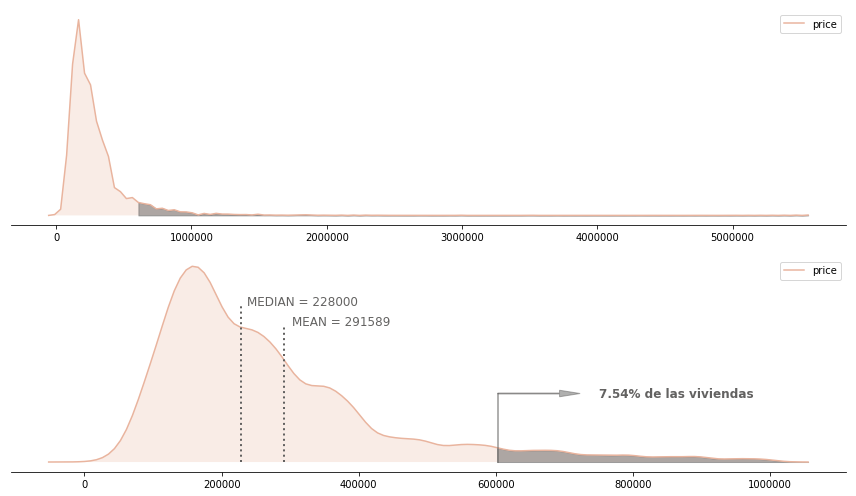

In [10]:
custome_distplot('price', df, up_clip=1000000, margin=600000)

Vemos que las medidas centrales (media y mediana) de los precios de las viviendas caen entre los 200.000 y 300.000€. Además, vemos que la distribución de los precios de las viviendas es asimétrica positiva, con una gran cola hacia la derecha. De ahí que, en este caso, la mediana parezca una medida central más significativa, ya que la media está fuertemente condicionada por los valores extremos de precios. 

Solo con la imágen superior podríamos decir ya que el precio de la vivienda no parece seguir una distribución normal. No obstante, verificamos la normalidad mediante un Q-Q plot:

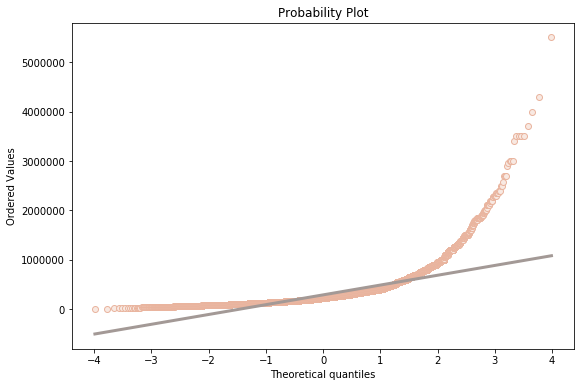

In [11]:
custome_qqplot('price', df)

Se comprueba que, en efecto, la distribución de precios se aleja mucho de una distribución normal.

### Superficie de las viviendas

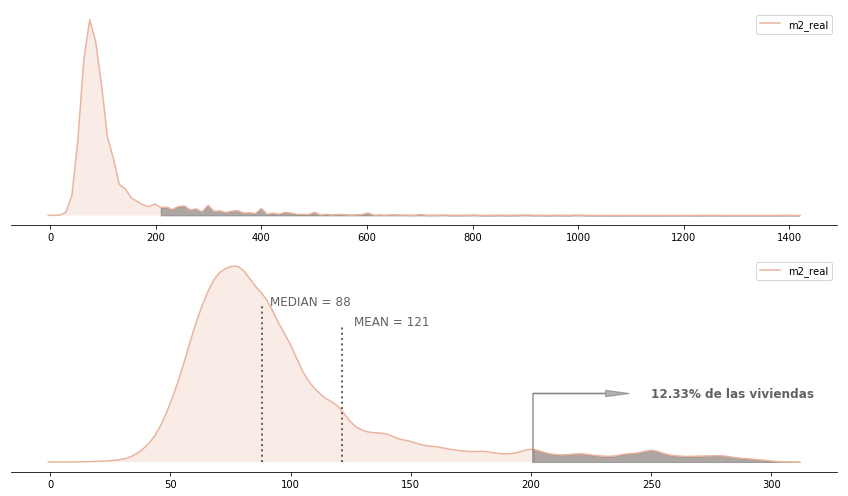

In [12]:
custome_distplot('m2_real', df, up_clip=300, margin=200)

En este caso, las medidas centrales (media y mediana) de los metros cuadrados de las viviendas caen en torno a los 100 $m^2$. Por otro lado, la distribución parece, nuevamente, asimétrica positiva, con una gran cola hacia la derecha. Por ello, parece que conviene emplear la mediana otra vez.

Verifiquemos la normalidad mediante un Q-Q plot:

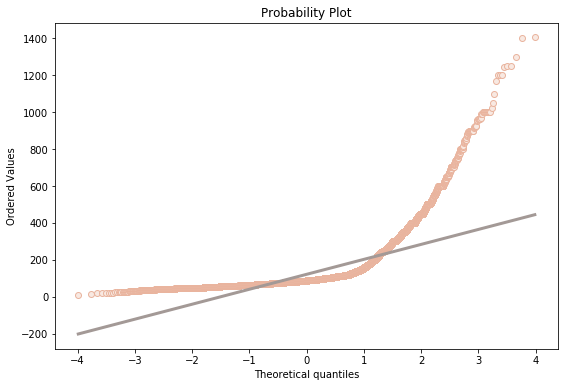

In [13]:
custome_qqplot('m2_real', df)

En esta ocasión también comprobamos que la variable no sigue una distribución normal.

### Número de baños de las viviendas

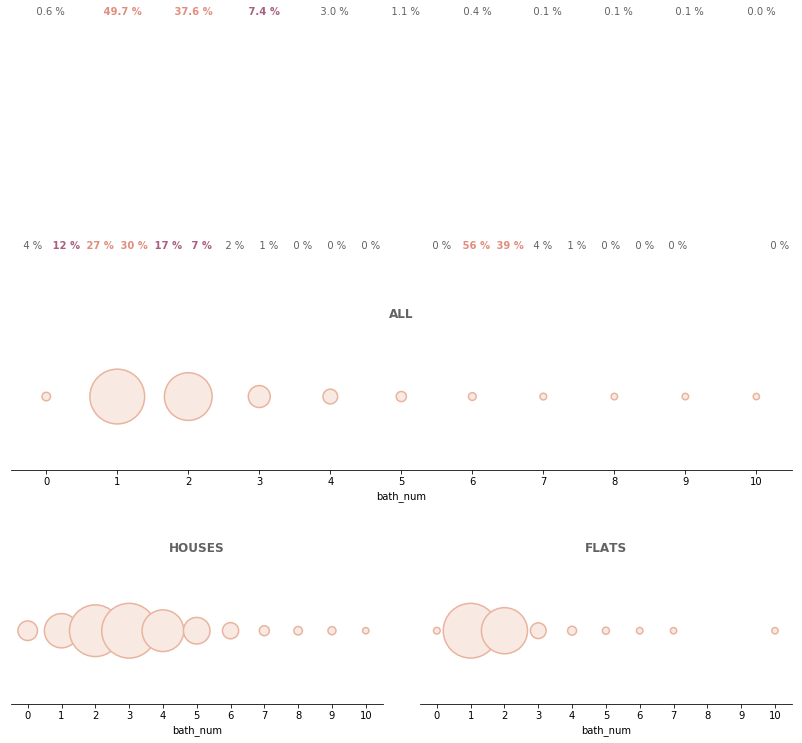

In [14]:
custome_countplot_multi('bath_num', df, df[houses], df[flats], perc=True)

Vemos que en las viviendas tipo casa, lo más común es que haya 2 o 3 baños, aunque también son frecuentes, en menor medida. 1, 4  o incluso 5 baños. Por otro lado, en las viviendas tipo pisos la gran mayoría consta de 1 o 2 baños.

### Número de habitaciones de las viviendas

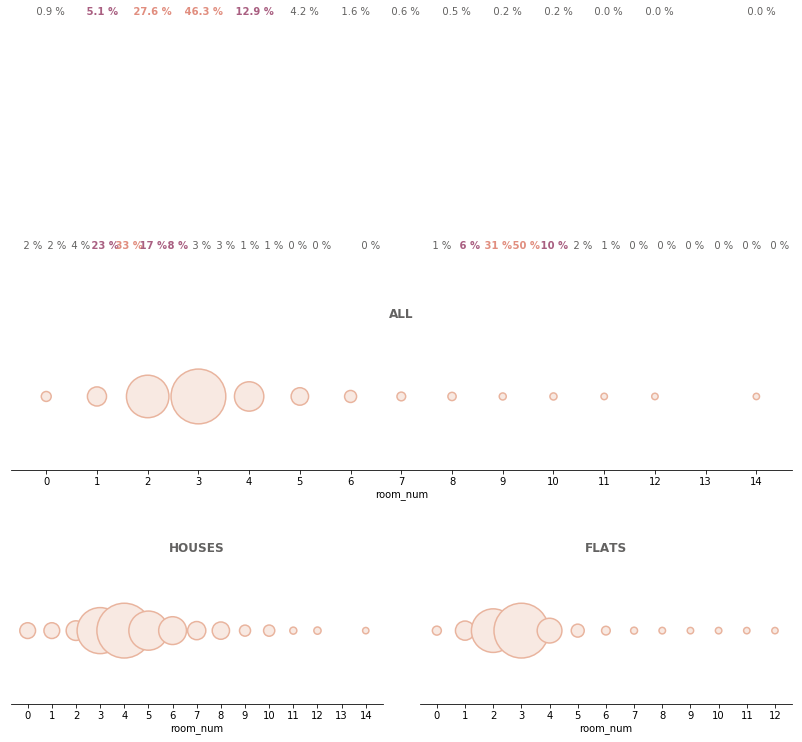

In [15]:
custome_countplot_multi('room_num', df, df[houses], df[flats], perc=True)

En lo que respecta al número de habitaciones, las viviendas tipo casa tienden a tener 4, aunque también son frecuentes las casas con 3 y 5 habitaciones, y en menor medida, 6. Por otro lado, la mitad de las viviendas tipo piso tienen 3 habitaciones, con un porcentaje muy elevado que tienen 2, y en menor medida, 1 o 4 habitaciones.

### Número de plantas de las viviendas

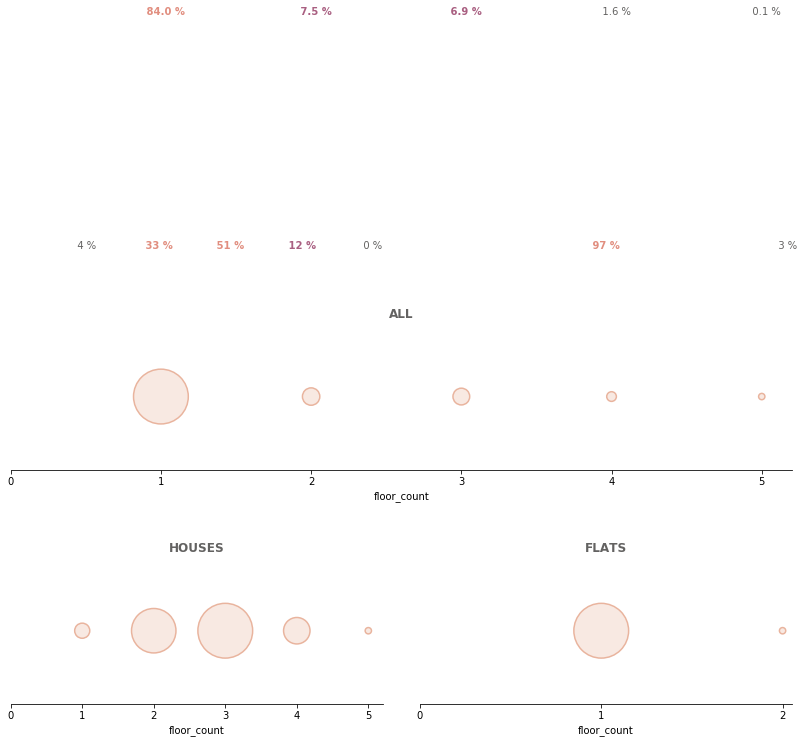

In [16]:
custome_countplot_multi('floor_count', df, df[houses], df[flats], perc=True)

Las viviendas tipo casa, tienden a tener mayoritariamente 3 plantas, aunque son frecuentes las viviendas con 2 plantas, y en menor medida, 4. Por otro lado, todas las viviendas tipo piso constan de una sola planta, excepto un porcentaje pequeño correspondiente a los áticos, que tiene 2.

### Número de piso de las viviendas

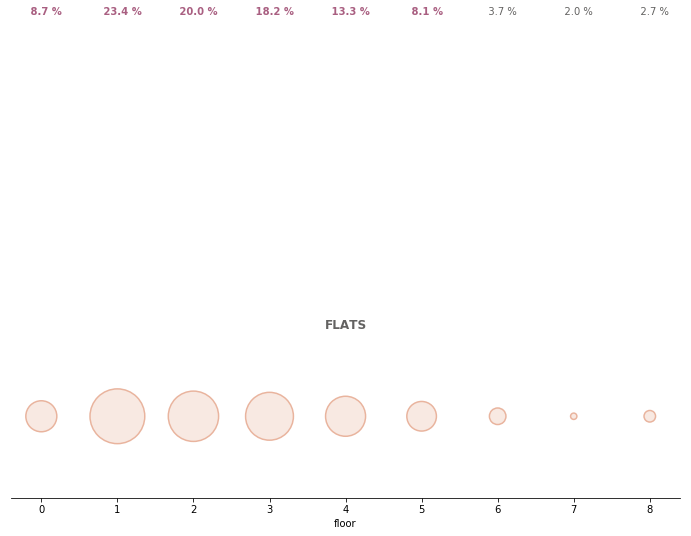

In [17]:
custome_countplot_single('floor', df[flats], perc=True, title='FLATS')

Vemos que los pisos en venta mayoritariamente corresponden a pisos ubicados en 1ª planta, aunque también son numerosos los pisos de las plantas 2ª y 3ª. En menor medida, tenemos pisos de 4ª y 5ª planta, y bajos. 

*En este caso observamos solo las viviendas tipo piso, ya que todas las casas están ubicadas en la planta baja.*

## Estudio de duplicidades

Finalmente, hacemos un breve estudio sobre las duplicidades de las variables:

In [18]:
n_records = len(df)
def duplicados_por_columna(df):
    for column in df:
        count_value = df[column].value_counts()
        common = count_value.iloc[0]
        rare = count_value.iloc[-1]
        if ((common / (1.0 * n_records)) > 0.7):
            print("Column:{} ## Common: {}% <> Rare: {}% ## Type: {}".format( df[column].name, 
                                       round(common / (n_records) * 100, 2), 
                                       round(rare / (n_records) * 100, 2),
                                       df[column].dtype
        ))
            
duplicados_por_columna(df)

Column:condition ## Common: 82.52% <> Rare: 3.96% ## Type: category
Column:house_type ## Common: 80.94% <> Rare: 0.03% ## Type: object
Column:air_conditioner ## Common: 98.36% <> Rare: 1.64% ## Type: bool
Column:balcony ## Common: 78.25% <> Rare: 21.75% ## Type: bool
Column:chimney ## Common: 99.37% <> Rare: 0.63% ## Type: bool
Column:garage ## Common: 71.06% <> Rare: 1.75% ## Type: category
Column:garden ## Common: 83.17% <> Rare: 16.83% ## Type: bool
Column:reduced_mobility ## Common: 89.0% <> Rare: 11.0% ## Type: bool
Column:swimming_pool ## Common: 96.22% <> Rare: 3.78% ## Type: bool
Column:indoor ## Common: 97.27% <> Rare: 2.73% ## Type: category
Column:floor_count ## Common: 83.99% <> Rare: 0.06% ## Type: int64
Column:ground ## Common: 92.62% <> Rare: 7.38% ## Type: bool


Como se puede ver en el resultado, tenemos 12 variables con mas del 70% de valores repetidos. Básicamente lo que vemos es que esas variables no están balanceadas. En caso de usarlas en nuestro modelo, se tendrá que tener en cuenta.

# Estudio de relaciones  entre las variables

En este apartado estudiaremos la relación que tienen las variables de nuestro conjunto de datos entre sí, primero mediante tests estadísticos, y luego mediante análisis gráfico.

## Test de correlación de Kendall

Empezaremos nuestro estudio de relaciones analizando las correlaciones de las variables numéricas y booleanas. Expondremos los resultados en un correlograma para que podamos identificar de manera visual e intuitiva qué variables están correlacionadas. Para ello, dado que hemos comprobado que las variables no siguen una distribución normal (al menos nuestra variable dependiente), emplearemos la correlación no paramétrica de **Kendall**:

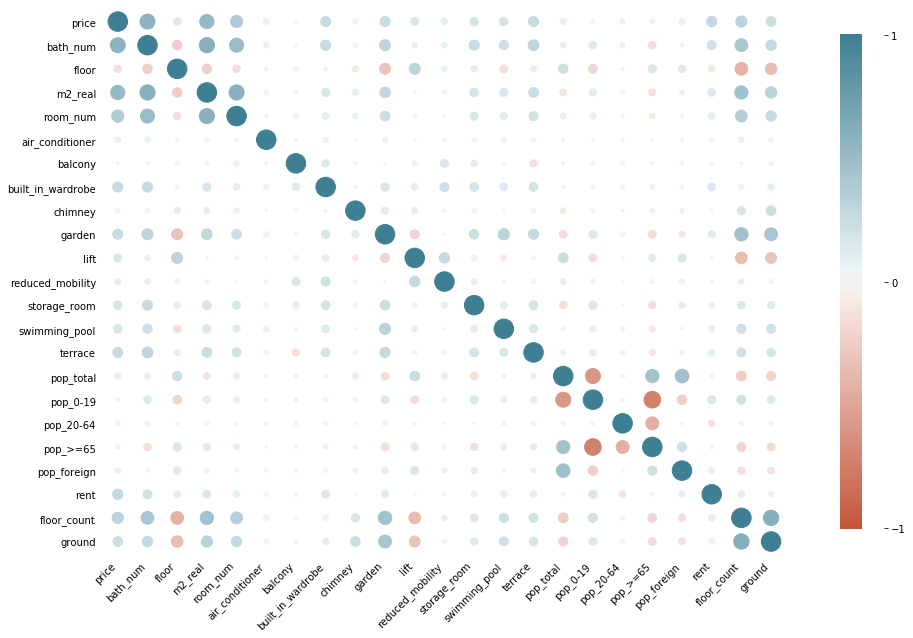

In [19]:
plt.figure(figsize=(14, 10))
custome_corrplot(df.corr(method='kendall'))

Del correlograma podemos extraer las siguientes conclusiones:

+ Hay variables que tienen una cierta correlación con la variable __<font color=#5F66A1>price</font>__, tales como  __<font color=#5F66A1>bath_num</font>__, __<font color=#5F66A1>m2_real</font>__, o en menor medida __<font color=#5F66A1>room_num</font>__, __<font color=#5F66A1>floor_count</font>__ o __<font color=#5F66A1>rent</font>__, entre otros..
+ Hay una familia de variables que parecen estar correlacionadas entre sí: __<font color=#5F66A1>bath_num</font>__, __<font color=#5F66A1>m2_real</font>__ y __<font color=#5F66A1>room_num</font>__ (además del ya mencionado precio).
+  __<font color=#5F66A1>pop_total</font>__, __<font color=#5F66A1>pop_0-19</font>__ y __<font color=#5F66A1>pop_>=65</font>__ están fuertemente correlacionadas (estas dos últimas con correlación inversa)
+ Las variables __<font color=#5F66A1>garden</font>__, y sobretodo __<font color=#5F66A1>ground</font>__ y __<font color=#5F66A1>floor_count</font>__ están relacionadas entre sí

## Test de Kruskal-Wallis

Para evaluar la posible relación entre las variables categóricas y nuestra variable dependiente __<font color=#5F66A1>price</font>__, usaremos un análisis de la varianza. Asi, por la misma razón que en el anterior caso, optaremos por un test no paramétrico, el test de **Kruskal-Wallis** en este caso:

In [20]:
from scipy.stats import kruskal

def calculate_kruskal(x, y='price'):

    df_dum = pd.get_dummies(df.filter([x,y]))

    for i in range(df_dum.shape[1]-1):
        df_dum.iloc[:,i+1] = np.where(df_dum.iloc[:,i+1]==1, df_dum[y], 0)

    df_dum = df_dum.drop(columns=[y])
    print(f"TEST KRUSKAL entre las variables {b}{x}{n} y {b}{y}{n} ...")
    print(kruskal(*[df_dum[col][df_dum[col]!=0] for col in df_dum.columns]))
    print("\n")

calculate_kruskal('house_type')
calculate_kruskal('garage')
calculate_kruskal('condition')
calculate_kruskal('loc_zone')
calculate_kruskal('loc_city')
calculate_kruskal('location')

TEST KRUSKAL entre las variables house_type y price ...
KruskalResult(statistic=3677.878556901696, pvalue=0.0)


TEST KRUSKAL entre las variables garage y price ...
KruskalResult(statistic=4217.743518017706, pvalue=0.0)


TEST KRUSKAL entre las variables condition y price ...
KruskalResult(statistic=228.7749588429416, pvalue=2.099659582948786e-50)


TEST KRUSKAL entre las variables loc_zone y price ...
KruskalResult(statistic=2011.2867049677272, pvalue=0.0)


TEST KRUSKAL entre las variables loc_city y price ...
KruskalResult(statistic=6366.157357384187, pvalue=0.0)


TEST KRUSKAL entre las variables location y price ...
KruskalResult(statistic=8991.784676280984, pvalue=0.0)




Observamos como el *p-value* es nulo (o prácticamente nulo) para cada una de las 6 variables, por lo que incluso optando por un nivel de significación muy bajo, tal como $\alpha$ 0.01 , concluiríamos en rechazar las hipótesis nulas y asumir que existen diferencias significativas en el precio de las viviendas en función de las distintas categorías.

## Relacion entre las variables  y el precio

Para profundizar más en relación a cómo varía el **precio de las viviendas** en función de las variables más relevantes, generaremos una serie de gráficos con los cuales nos valdremos para extraer algunas conclusiones.

### ¿Cómo influye el tipo de vivienda en su precio?

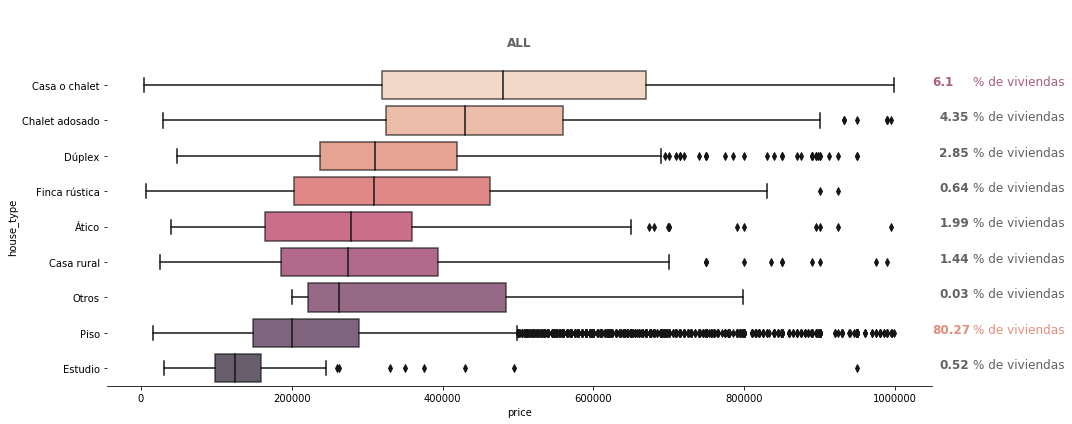

In [21]:
custome_boxplot('house_type', order=True, title='ALL')

Vemos que las casas y chalets son el tipo de viviendas más caras, con la mediana por encima de los 400.000€. Por otro lado, los tipos de casa más baratos son los pisos (a excepción de los estudios), los cuales tienen la mediana en torno a los 200.000€, prácticamente la mitad que en el caso de las casas y chalets. Además, vemos que los áticos y los dúplex tienden a ser considerablemente más caros que los pisos que no lo son, al igual que las fincas y casas rurales tienden a ser más baratas que los chalets.

### ¿Cómo influye el estado de la vivienda en su precio?

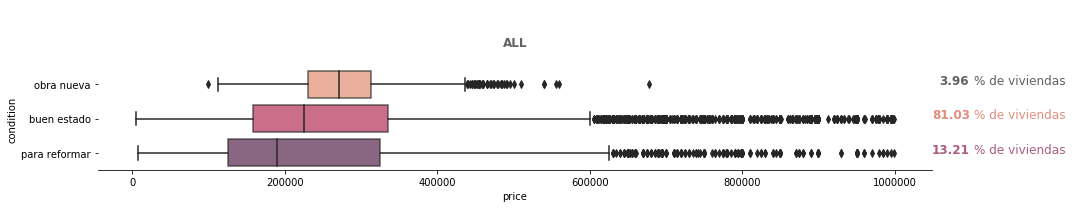

In [22]:
custome_boxplot('condition', order=True, title='ALL')

Vemos que el estado de las viviendas tiene influencia en el precio. Así, las viviendas más caras son las de obra nueva, y las que menos, las que necesitan reformas, lo cual entra dentro de lo esperado.

### ¿Cómo influye el número de baños de una vivienda en su precio?

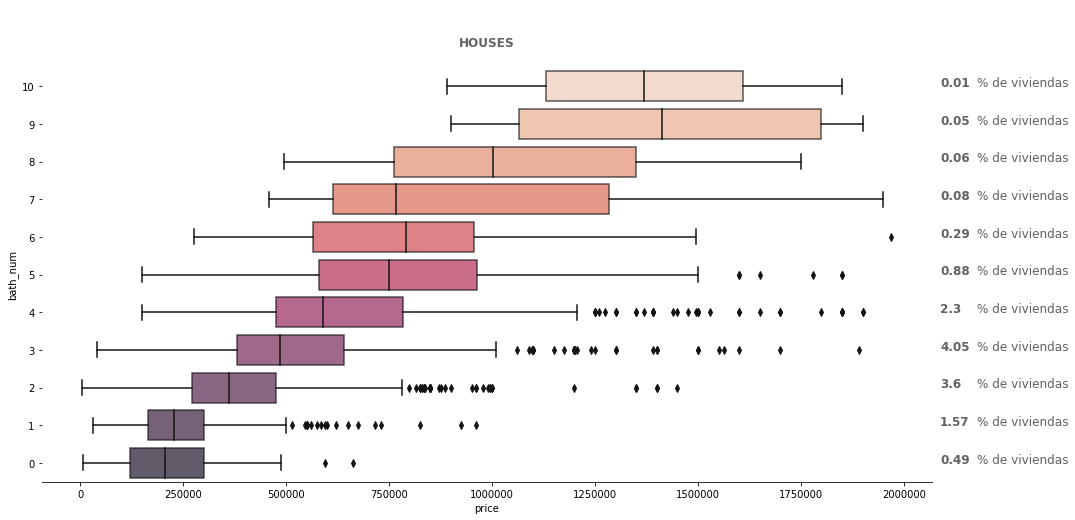

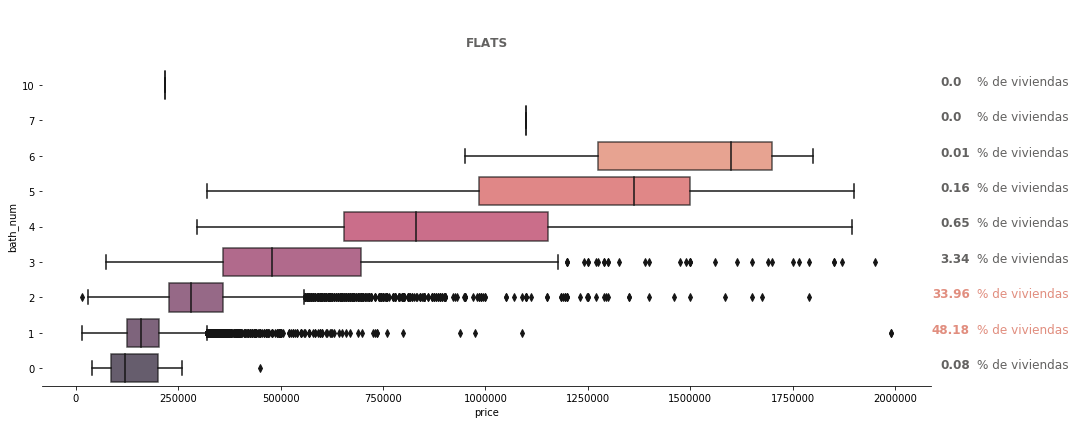

In [23]:
(df[houses].query('price<2000000')
 .pipe((custome_boxplot, 'data'), 'bath_num', title="HOUSES"))

(df[flats].query('price<2000000')
 .pipe((custome_boxplot, 'data'), 'bath_num', title="FLATS"))

Vemos que, tanto en viviendas tipo chalets, como en viviendas tipo piso, hay una considerable relación lineal entre el número de baños y el precio de las viviendas.

### ¿Cómo influye el número de habitaciones de una vivienda en su precio?

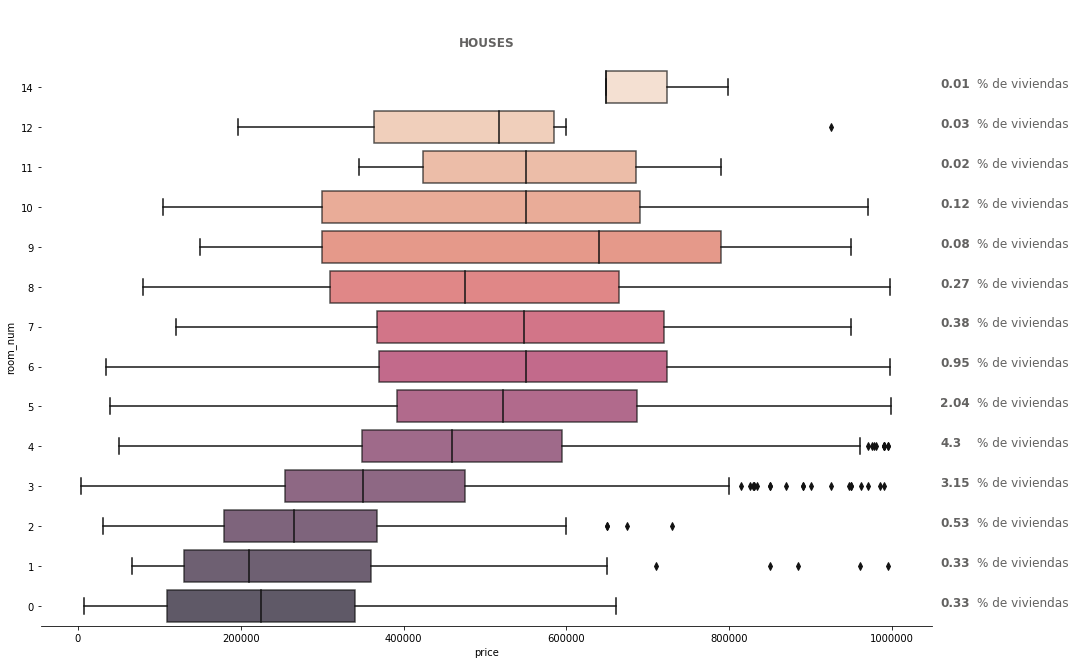

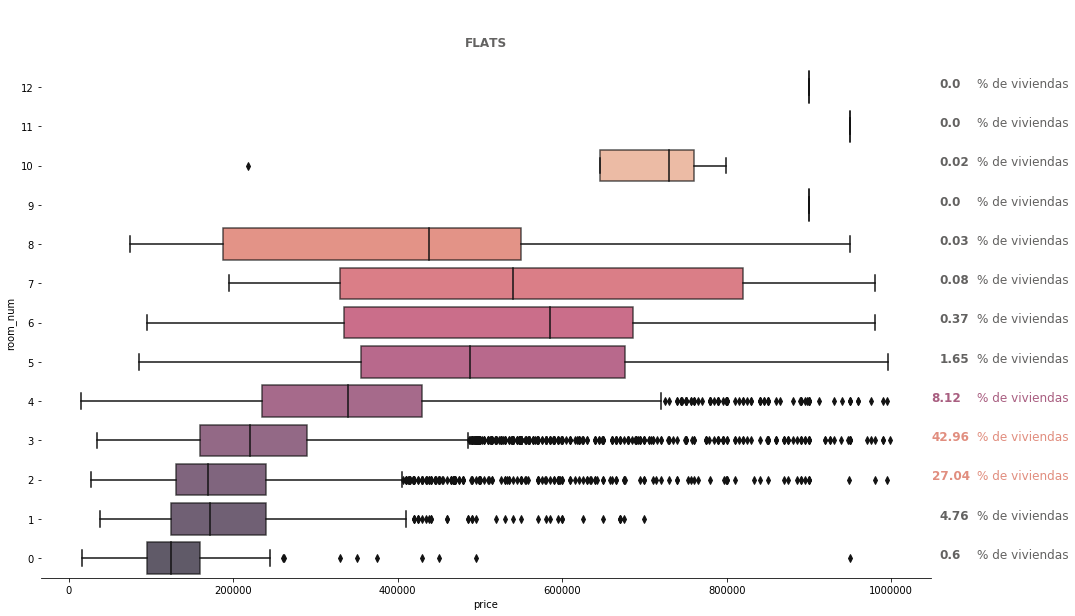

In [24]:
(df[houses].query('price<1000000')
 .pipe((custome_boxplot, 'data'), 'room_num', title="HOUSES"))

(df[flats].query('price<1000000')
 .pipe((custome_boxplot, 'data'), 'room_num', title="FLATS"))

En este caso, si bien no de forma tan clara como con el número de baños, se observa que el número de habitaciones también está relacionado con el precio de las viviendas tanto en los pisos como en las casas/chalets.

### ¿Cómo influye el número de planta de un piso en su precio?

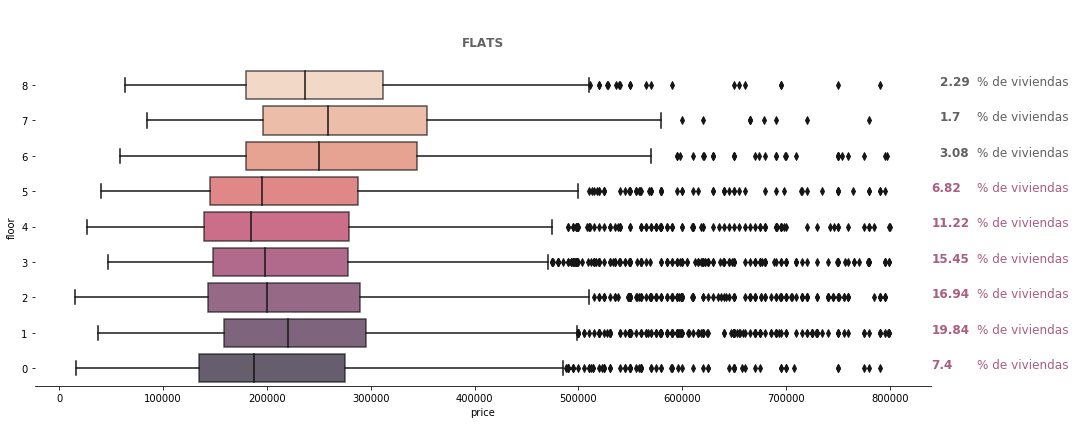

In [25]:
(df[flats].query('price<800000')
 .pipe((custome_boxplot, 'data'), 'floor', title="FLATS"))

En vista de lo que se observa en el gráfico, en principio no parece haber una relación muy clara entre el precio de las piso y el número de planta en el que éstos se ubican, si bien es cierto que los más caros parecen ser aquellos ubicados por encima de la 5ª planta. Por debajo, parece que tienden a costar ligeramente más aquellos ubicados en la 1ª planta que los de la 2ª, 3ª, 4ª o 5ª.

### ¿Cómo influye el número de plantas de las casas en su precio?

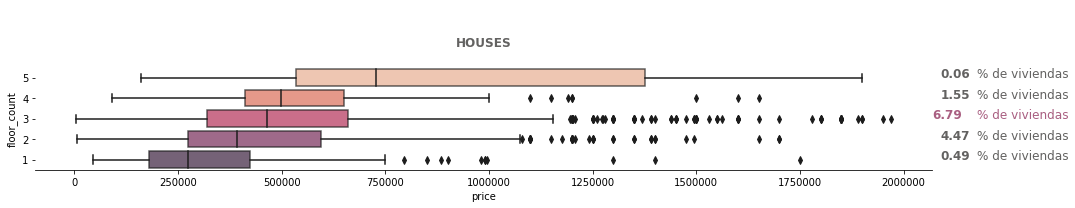

In [26]:
(df[houses].query('price<2000000')
 .pipe((custome_boxplot, 'data'), 'floor_count', title="HOUSES"))

Parece que el número de plantas que tienen las casas también tiene tiene una cierta relación lineal con su precio.

### ¿Cómo influye el garaje en el precio de las viviendas?

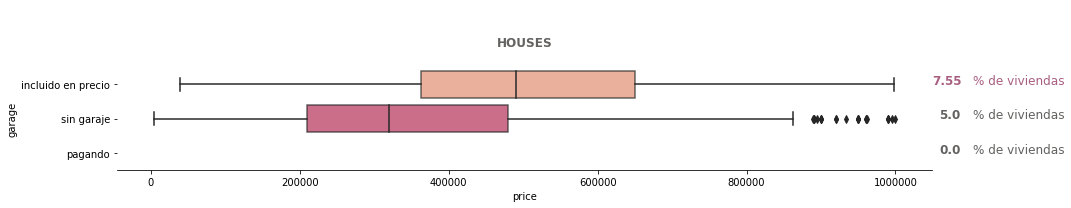

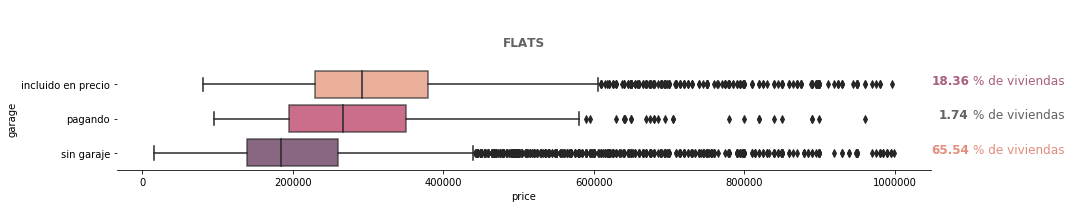

In [27]:
(df[houses]
 .query('price<1000000')
 .pipe((custome_boxplot,'data'), 'garage', order=True, title="HOUSES"))

(df[flats]
 .query('price<1000000')
 .pipe((custome_boxplot,'data'), 'garage', order=True, title="FLATS"))

Se observa como el garaje tiene también una influencia muy nítida en el precio de las viviendas, habiendo una diferencia sustancial entre las viviendas que ofrecen garaje incluido en el precio, entre las que lo ofertan pero pagando un extra, y entre aquellas que no tienen siquiera garaje

### ¿Cómo influyen los equipamientos de las viviendas en su precio?

Para empezar, rescatemos el correlograma del antes, centrándonos esta vez sólo en el precio y los equipamientos de las viviendas:

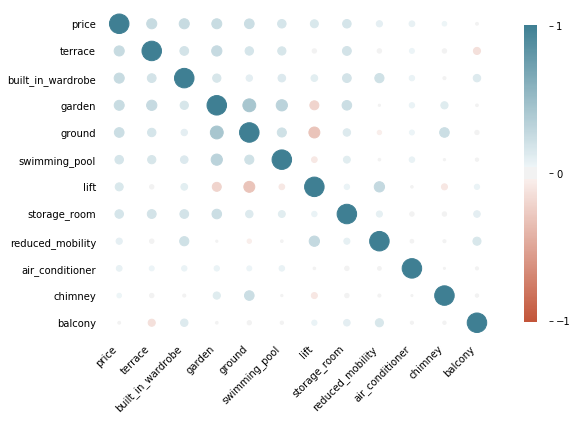

In [28]:
equip = ['price', 'terrace', 'built_in_wardrobe', 'garden', 'ground', 'swimming_pool', 'lift'
        , 'storage_room', 'reduced_mobility', 'air_conditioner', 'chimney', 'balcony']

plt.figure(figsize=(8, 6))
df.filter(items = equip).corr(method='kendall').pipe(custome_corrplot)

Podemos observar que, excepto __<font color=#5F66A1>balcony</font>__, __<font color=#5F66A1>chimney</font>__, y tal vez __<font color=#5F66A1>air_conditioner</font>__ y __<font color=#5F66A1>reduced_mobility</font>__, los equipamientos sí parecen tener cierta influencia en el precio de las viviendas.

Comprobemos cómo es esta influencia con una serie de boxplots:

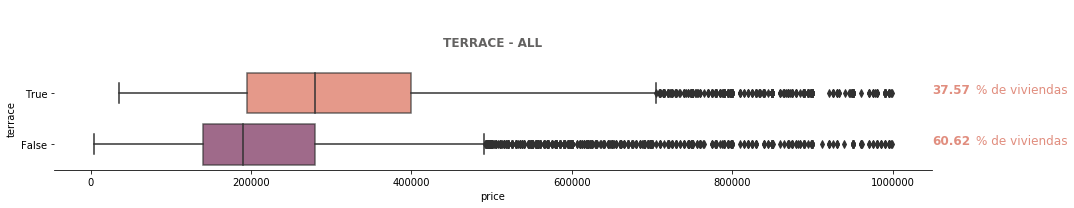

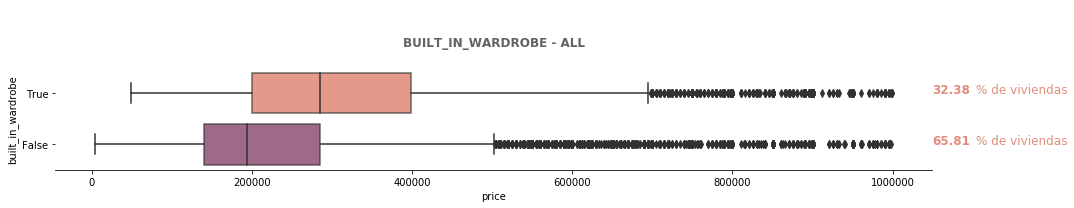

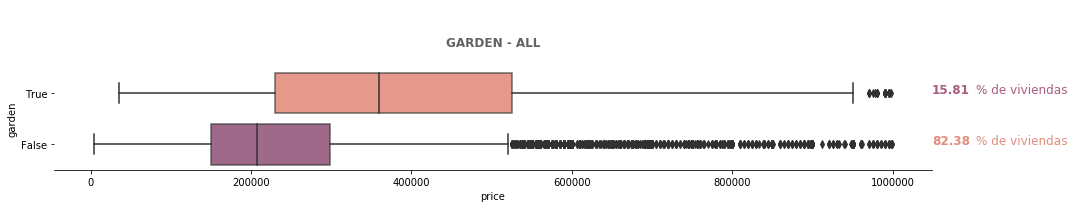

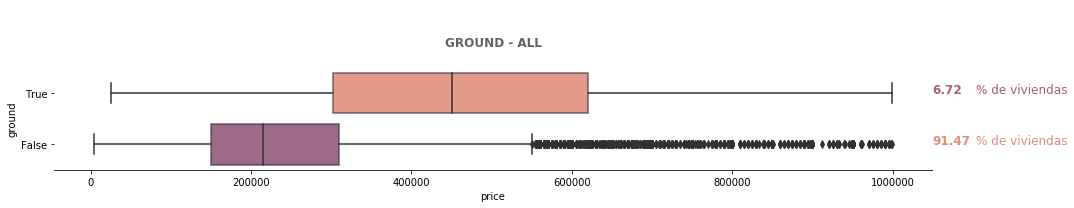

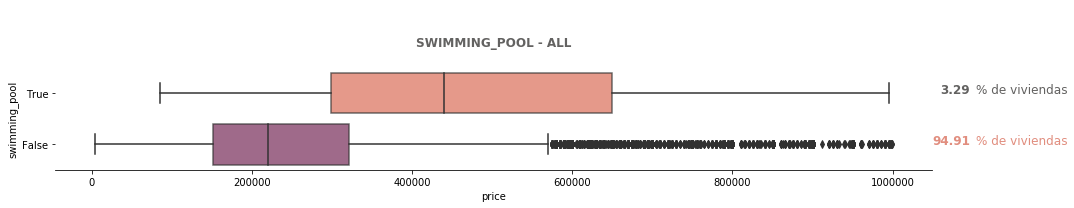

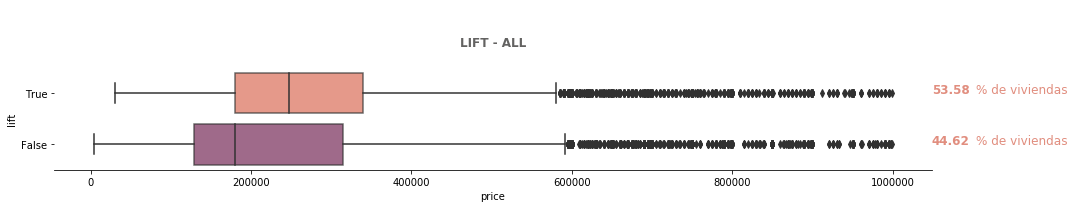

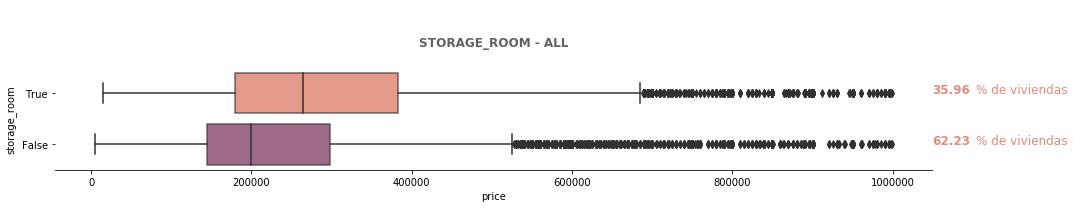

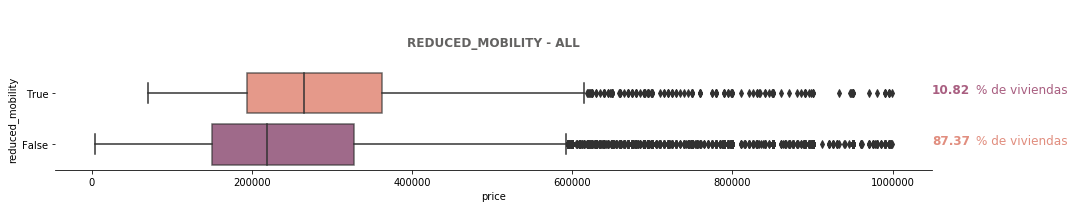

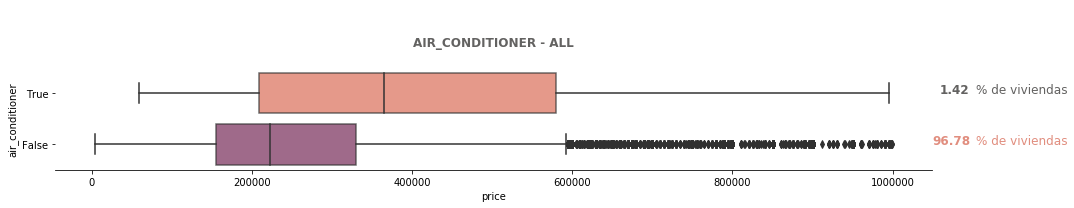

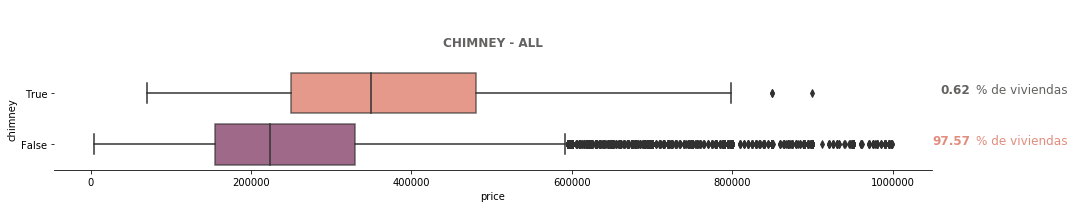

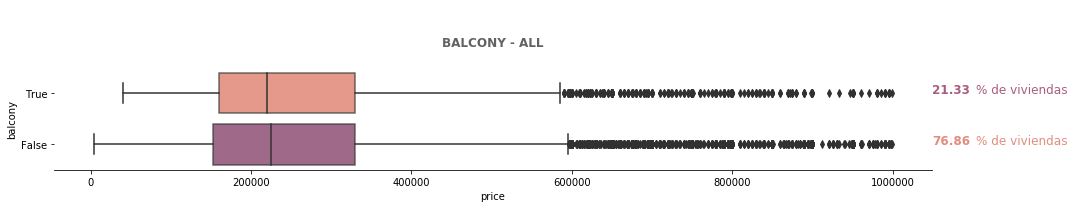

In [29]:
for e in equip[1:]:
    custome_boxplot(e, title=f'{e.upper()} - ALL', data=df.query('price < 1000000'))

En vista de los gráficos, podríamos decir que todos los equipamientos, a excepción de los balcones, influyen en el precio de las viviendas, incluso las chimeneas, el aire acondicionado y el hecho de estar adaptadas para personas con movilidad reducida. No obstante, solo el 0.62% de las viviendas en venta tiene chimenea, y solo el 1.42% de las viviendas tiene aire acondicionado, por lo que puede que no sean muy significativas.

### ¿Cómo influyen los metros cuadrados de una de casa en su precio?

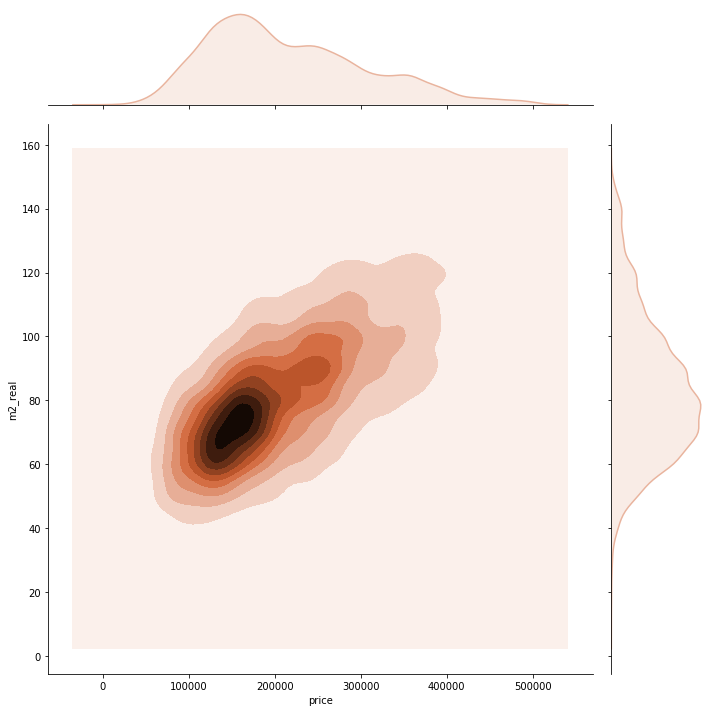

In [30]:
(df.query('price < 500000 and m2_real < 150')
 .pipe((sns.jointplot, 'data'), x="price", y="m2_real", kind="kde", color='#e9b49e', height=10));

Vemos que hay una clara relación entre los metros cuadrados de las viviendas y su precio. Esta relación, además, parece bastante lineal, ya que a medida que incrementan los metros cuadrados de una vivienda, el precio tiende a incrementar de forma proporcional.

### ¿Cómo influye la renta media poblacional en el precio de las viviendas?

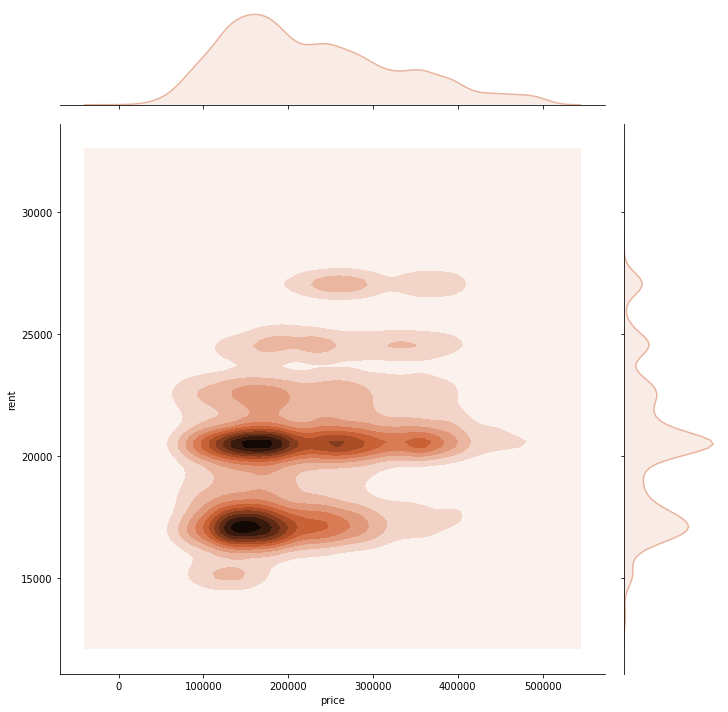

In [31]:
(df.query('price < 500000')
 .pipe((sns.jointplot, 'data'), x="price", y="rent", kind="kde", color='#e9b49e', height=10));

En vista de lo que observamos en el gráfico, no podemos saber en qué medida afecta la renta poblacional en el precio de las viviendas. No obstante, sí se distinguen 2 claros bloques en la renta poblacional, uno en torno a los 21000€ anuales, y otro en torno. a los 17000€. Asimismo, vemos que la media de precios de viviendas en ambos casos es muy similar, con una ligera proporción de vivienas más caras en las poblaciones con renta en torno a los 21000€.

Sin embargo, cabe recordar que la variable __<font color=#5F66A1>rent</font>__ nos muestra la renta poblacional de cada municipio/ciudad, no diferenciando un barrio de otro, lo cual podría ser de suma relevancia en ciudades pobladas como Bilbao o San Sebastián.

### ¿Cómo influye la ubicación de las viviendas en su precio?

Para descubrir cómo influye la ubicacion de las viviendas en el precio, empezemos por desglosar las zona geográficas de nuestras 2 provincias, y ver la distribución de precios para cada una de ellas.

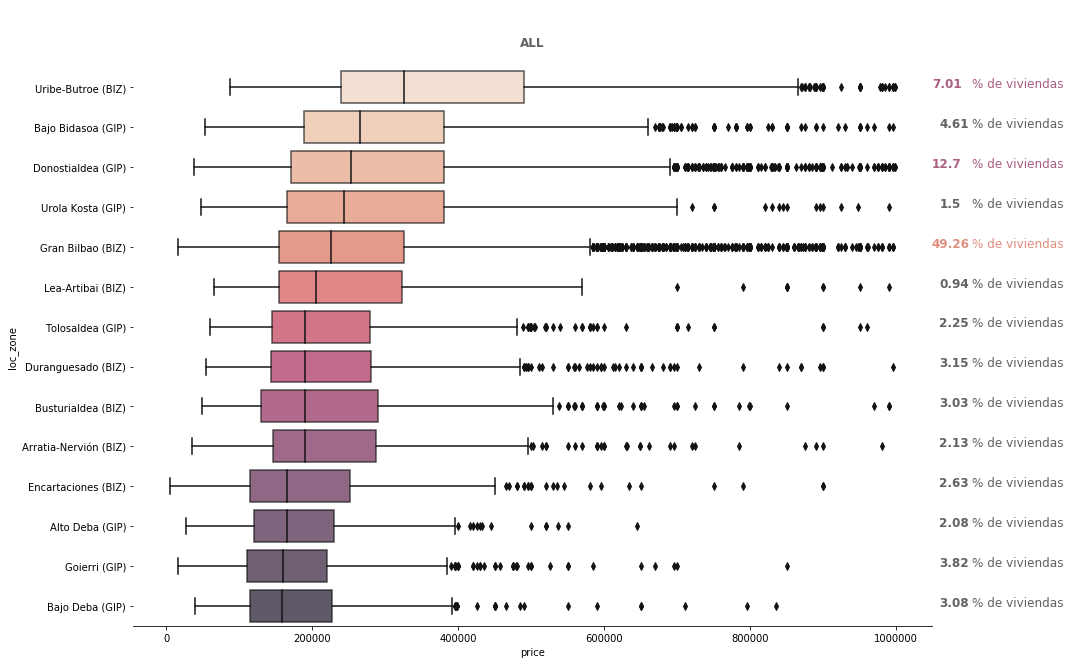

In [32]:
custome_boxplot('loc_zone', order=True, title='ALL')

Encontramos que, de zona a zona, los precios varían. En algunos casos esta variación es apenas distinguible, como en los casos de **Alto Deba** y **Bajo Deba**, ambos contiguos. Pero si comparamos las viviendas de estas zonas con **Bajo Bidasoa**, por ejemplo, vemos que la diferencia es ya suficientemente apreciable.

Por otro lado, exploremos más a fondo la distribución de nuestras viviendas en relación al número de viviendas en venta, cogiendo esta vez todas las viviendas sin ningún límite de precio (en el gráfico superior habíamos limitado el precio en 1 millón de €)

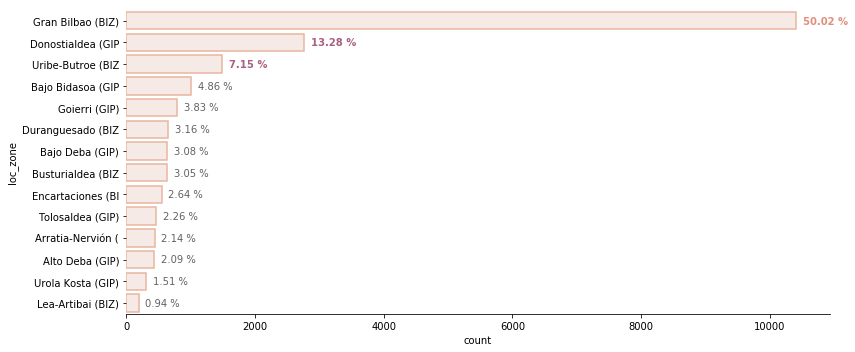

In [33]:
custome_barplot('loc_zone', df, 12, 5)

Vemos que hay zonas con muchas más viviendas que otras. Así, la mitad de las viviendas en venta de nuestro *dataset* se ubican en la zona de **Gran Bilbao**. Por ello, puede resultar interesante aumentando un tanto lupa y desglosar las ubicaciones en función de municipios. Veamos cuáles son los 20 municipios que mas viviendas tienen en la zona de Gran Bilbao:

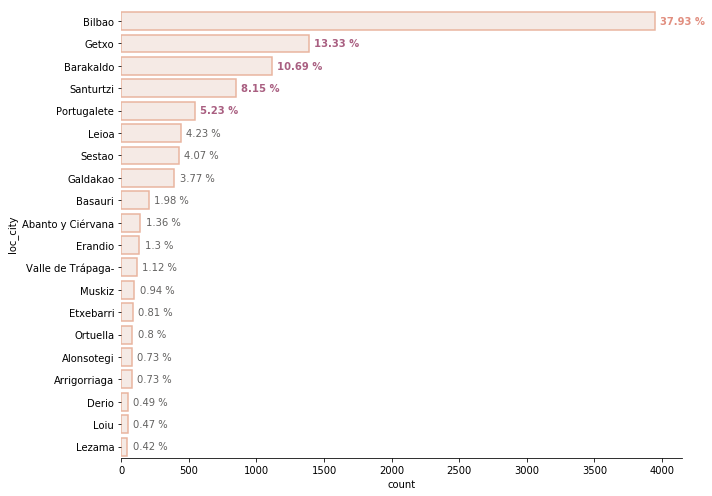

In [34]:
(df[df.loc_zone=="Gran Bilbao (BIZ)"]
.pipe((custome_barplot, 'data'), 'loc_city', figW=10, figH=7))

Vemos que, la ciudad de **Bilbao** recoge más de un tercio de las viviendas de nuestro conjunto de datos, por lo tanto, aumentemos aún más la lupa, observando los 20 barrios con más viviendas:

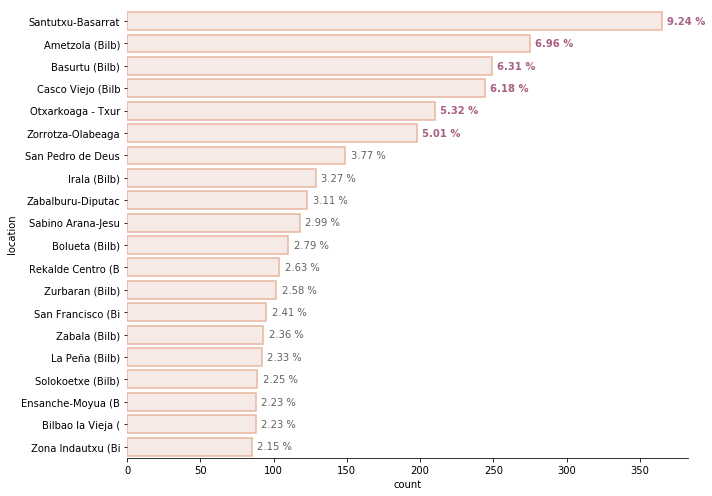

In [35]:
(df[df.loc_city=="Bilbao"]
.pipe((custome_barplot, 'data'), 'location', figW=10, figH=7))

Aunque aún tengamos barrios que congregan una gran cantidad de viviendas, vemos que la distribución por barrios parece ya algo más equilibrada. Por lo tanto, veamos si de barrio a barrio hay varaciones en el precio de las viviendas:

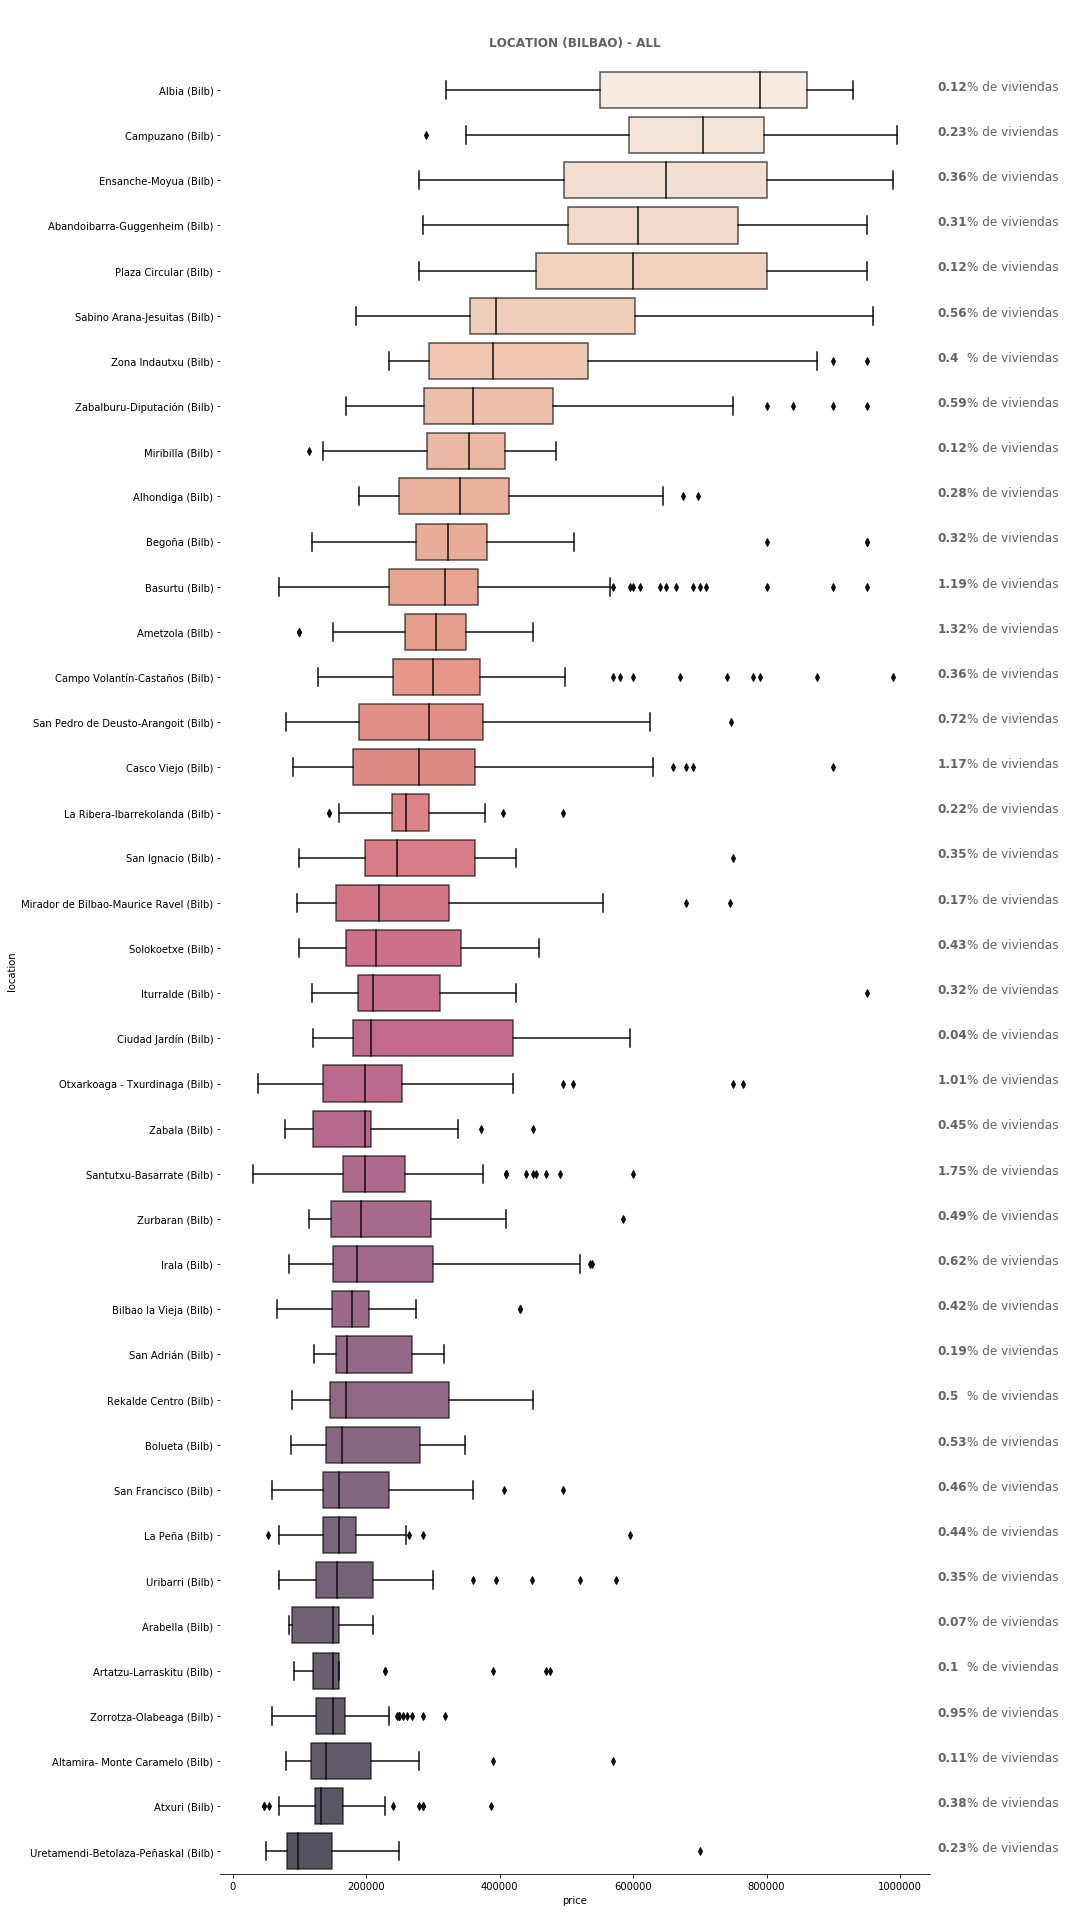

In [36]:
(df.query('price<1000000 and loc_city=="Bilbao"')
 .pipe((custome_boxplot,'data'), 'location', order=True, title="LOCATION (BILBAO) - ALL"))

Volvemos a ver que la diferencia de precios de las viviendas está muy ligada con la localización, mucho más si cabe a nivel de barrios. Así, mientras que en el barrio más económico de Bilbao, la mediana de las viviendas está en torno a los 100.000€, en el barrio más caro, la cifra asciende a los 800.000€. 

## Otras relaciones entre variables

Una vez hemos analizado cómo influyen en el precio las diferentes características de las viviendas, nos puede resultar también interesante explorar otras relaciones distintas que no tengan que ver con el precio. Así, en esta última sección profundizaremos brevemente en estas relaciones, nuevamente valiéndonos de gráficos.

### ¿Cómo influye la renta media poblacional en el tipo de viviendas en venta?

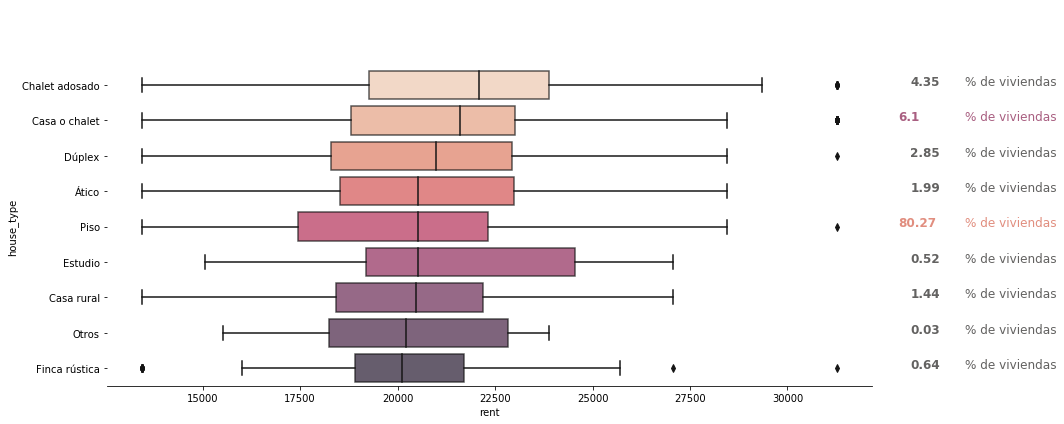

In [37]:
custome_boxplot('house_type', 'rent', order=True)

Vemos que, si bien muy ligeramente, la renta poblacional parece guardar cierta relación con el tipo de viviendas en venta. Así, allí donde las rentas más altas, se observa un ligero aumento de viviendas tipo chalet o dúplex.

### ¿Hay relación entre los metros cuadrados de una vivienda y su número de habitaciones?

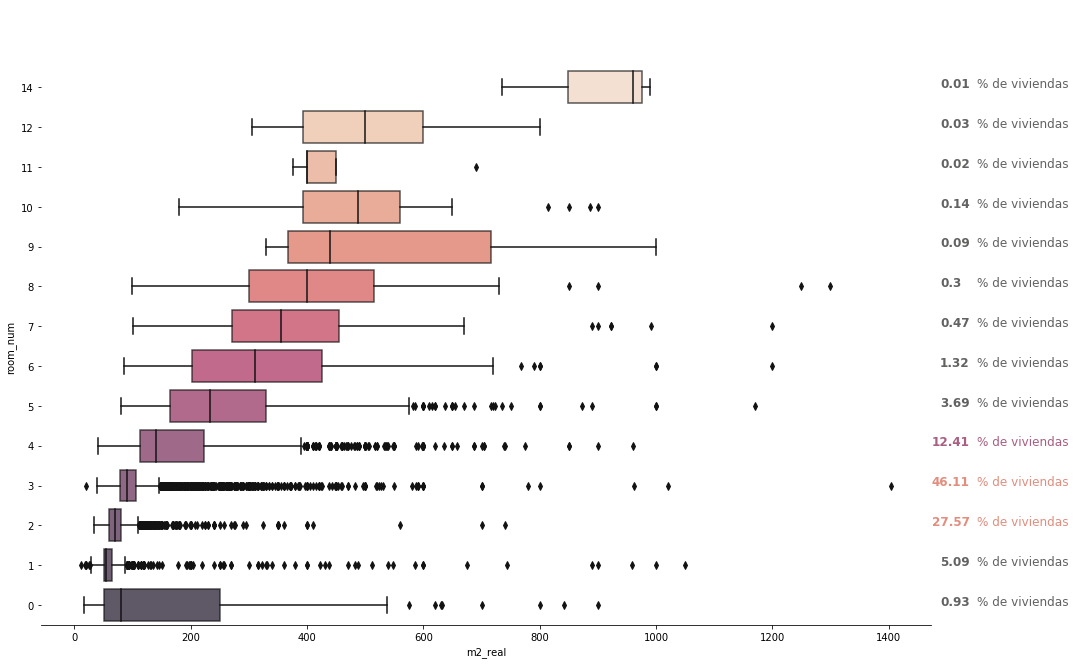

In [38]:
custome_boxplot('room_num', 'm2_real')

Se observa que, tal y como cabría esperar, la relación entre el número de habitaciones y los metros cuadrados de una casa es bastante lineal.

### ¿Hay relación entre los metros cuadrados de una vivienda y su número de baños?

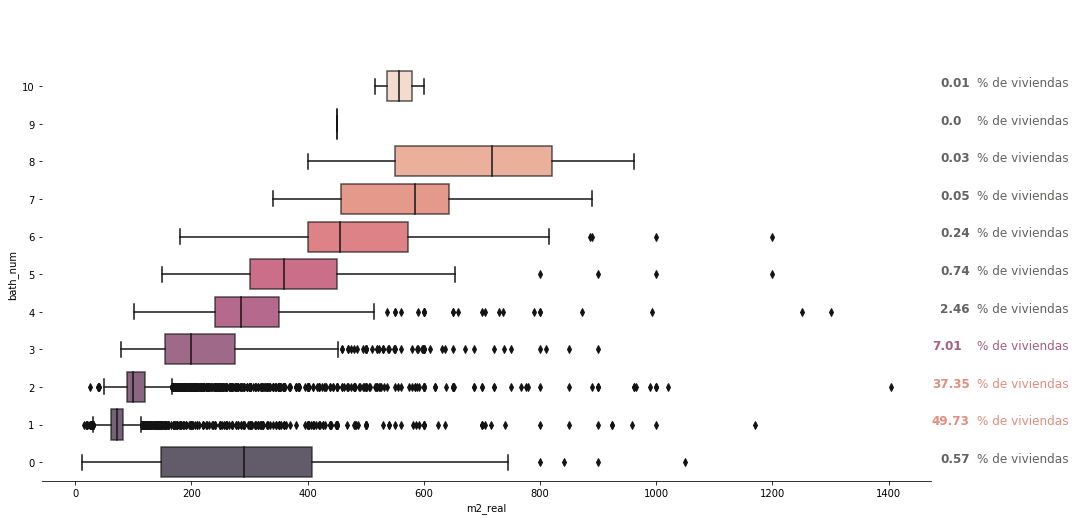

In [39]:
custome_boxplot('bath_num', 'm2_real')

Nuevamente vemos que existe una la relación directa entre el número de baños y los metros cuadrados de una casa es bastante lineal, lo cual vuelve a ser del todo esperado.